In [1]:
!pip install feature_engine

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr, ttest_ind
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from feature_engine.outliers import Winsorizer
from lightgbm import LGBMClassifier



import pickle
import json

warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv("/content/drive/MyDrive/HACKATHON/customer_risk1.csv")

In [5]:
def cardinality_check(data, list_cols):
    """
    Fungsi untuk mengecek kardinalitas (jumlah nilai unique) dari kolom-kolom tertentu

    Parameters:

    data : pd.DataFrame
        DataFrame yang akan dicek
    list_cols : list
        List nama kolom yang akan dicek kardinalitasnya

    Returns:

    pd.DataFrame
        DataFrame berisi informasi kardinalitas setiap kolom
    """

    results = []

    for col in list_cols:
        # Hitung jumlah unique values
        n_unique = data[col].nunique()
        unique_values = data[col].unique()

        # Format tampilan unique values - tampilkan semua
        unique_display = list(unique_values)

        results.append({
            'Nama Kolom': col,
            'Jumlah Unique': n_unique,
            'Nilai Unique': unique_display
        })

    result_df = pd.DataFrame(results)
    return result_df

pd.set_option('display.max_colwidth', None)
cardinality_check(df, df)

Nama Kolom  Jumlah Unique  \
0           Unnamed: 0          12005   
1      customer_number          12005   
2     principal_amount             28   
3   outstanding_amount           1027   
4    outstanding_ratio            855   
5                  dpd            146   
6        is_delinquent              2   
7         avg_bill_gap           1853   
8           late_ratio             99   
9           paid_ratio           1336   
10      marital_status              2   
11           age_group              4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12005 entries, 0 to 12004
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          12005 non-null  int64  
 1   customer_number     12005 non-null  object 
 2   principal_amount    12005 non-null  float64
 3   outstanding_amount  12005 non-null  float64
 4   outstanding_ratio   12005 non-null  float64
 5   dpd                 12005 non-null  int64  
 6   is_delinquent       12005 non-null  int64  
 7   avg_bill_gap        12005 non-null  float64
 8   late_ratio          12005 non-null  float64
 9   paid_ratio          12005 non-null  float64
 10  marital_status      12005 non-null  object 
 11  age_group           12005 non-null  object 
dtypes: float64(6), int64(3), object(3)
memory usage: 1.1+ MB


In [7]:
df = df.drop(["Unnamed: 0", "customer_number"], axis=1)

In [8]:
df.head()

,principal_amount,outstanding_amount,outstanding_ratio,dpd,is_delinquent,avg_bill_gap,late_ratio,paid_ratio,marital_status,age_group
0,4500000.0,1890000.0,0.42000,0,0,-6.22,0.60,1.000000,MARRIED,adult
1,5000000.0,2300000.0,0.46000,0,0,-0.68,0.08,0.880000,MARRIED,senior
2,5000000.0,3133700.0,0.62674,47,1,-0.80,0.06,0.374959,MARRIED,adult
3,8000000.0,3520000.0,0.44000,0,0,-6.62,0.12,1.000000,MARRIED,young
4,8000000.0,3520000.0,0.44000,0,0,-0.56,0.42,0.820000,MARRIED,mature


In [9]:
X = df.drop(columns=['dpd',"is_delinquent"])
y = df['is_delinquent']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape}")
print(f"Test size: {X_test.shape}")

Train size: (9604, 8)
Test size: (2401, 8)


In [10]:
numeric_cols = ["principal_amount", "outstanding_amount", "outstanding_ratio", "avg_bill_gap", "late_ratio", "paid_ratio"]
# Hitung skewness untuk semua kolom numerik
skewness = X_train[numeric_cols].skew()

# Statistik deskriptif
desc = X_train[numeric_cols].describe().T  # transpose biar kolom = metrik, baris = feature

# Gabungkan keduanya
summary = desc.join(skewness.rename("skewness"))

print(summary)

                     count          mean           std        min         25%  \
principal_amount    9604.0  5.896137e+06  1.550435e+06  1000000.0  5000000.00   
outstanding_amount  9604.0  2.794309e+06  1.009830e+06        0.0  2200000.00   
outstanding_ratio   9604.0  4.717399e-01  9.477345e-02        0.0        0.42   
avg_bill_gap        9604.0 -5.326424e+00  7.927553e+00     -138.4      -10.06   
late_ratio          9604.0  1.799642e-01  1.691672e-01        0.0        0.08   
paid_ratio          9604.0  8.512253e-01  2.290990e-01        0.0        0.84   

                           50%         75%           max  skewness  
principal_amount    5000000.00  7000000.00  2.700000e+07  1.867993  
outstanding_amount  2400000.00  3200000.00  1.653196e+07  2.286843  
outstanding_ratio         0.46        0.48  1.000000e+00  1.413148  
avg_bill_gap             -4.52       -0.30  5.493750e+01 -3.953903  
late_ratio                0.12        0.20  9.583333e-01  1.950966  
paid_ratio        

In [11]:

outlier_summary = {}

for col in numeric_cols:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Hitung jumlah outlier
    outliers = X_train[(X_train[col] < lower_bound) | (X_train[col] > upper_bound)][col]
    outlier_pct = len(outliers) / len(X) * 100

    outlier_summary[col] = {
        "Jumlah Outlier": len(outliers),
        "Persentase Outlier (%)": round(outlier_pct, 2),
        "Min": X_train[col].min(),
        "Max": X_train[col].max()
    }

for col, stats in outlier_summary.items():
    print(
        f"{col:<15} | "
        f"Jumlah Outlier: {stats['Jumlah Outlier']:<5} | "
        f"Persentase: {stats['Persentase Outlier (%)']:<6}% | "
        f"Min: {stats['Min']:<10} | "
        f"Max: {stats['Max']:<10}"
    )

principal_amount | Jumlah Outlier: 126   | Persentase: 1.05  % | Min: 1000000.0  | Max: 27000000.0
outstanding_amount | Jumlah Outlier: 558   | Persentase: 4.65  % | Min: 0.0        | Max: 16531964.0
outstanding_ratio | Jumlah Outlier: 1069  | Persentase: 8.9   % | Min: 0.0        | Max: 1.0       
avg_bill_gap    | Jumlah Outlier: 133   | Persentase: 1.11  % | Min: -138.4     | Max: 54.9375   
late_ratio      | Jumlah Outlier: 1157  | Persentase: 9.64  % | Min: 0.0        | Max: 0.9583333333333334
paid_ratio      | Jumlah Outlier: 1547  | Persentase: 12.89 % | Min: 0.0        | Max: 1.0       


In [12]:
X_train

,principal_amount,outstanding_amount,outstanding_ratio,avg_bill_gap,late_ratio,paid_ratio,marital_status,age_group
9799,7000000.0,3220000.0,0.460000,-13.76,0.06,1.000000,MARRIED,mature
1685,8000000.0,5183000.0,0.647875,4.78,0.22,0.366714,MARRIED,young
11068,5000000.0,2300000.0,0.460000,-12.36,0.04,1.000000,MARRIED,adult
8535,5000000.0,2100000.0,0.420000,-9.58,0.08,1.000000,MARRIED,mature
10464,8000000.0,3360000.0,0.420000,-10.22,0.08,1.000000,MARRIED,mature
...,...,...,...,...,...,...,...,...
1892,5000000.0,2400000.0,0.480000,-3.82,0.60,1.000000,WIDOWED,adult
4353,5000000.0,2000000.0,0.400000,-10.06,0.02,1.000000,MARRIED,adult
6518,5000000.0,2300000.0,0.460000,-4.66,0.26,1.000000,MARRIED,adult
4025,5000000.0,2200000.0,0.440000,-10.58,0.12,1.000000,MARRIED,mature


In [13]:
# Feature selection Numerical columns
p_values = []
interpretasi = []
cols = []
corrs = []

for col in numeric_cols:
    corr_coef, p_value = pointbiserialr(X_train[col], y_train)

    p_values.append(p_value)
    cols.append(col)
    corrs.append(corr_coef)

    if p_value < 0.05:
        interpretasi.append('ada korelasi')
    else:
        interpretasi.append('tidak ada korelasi')

hasil = pd.DataFrame({
    'nama kolom': cols,
    'corr_coef': corrs,
    'p_value': p_values,
    'hasil': interpretasi
})

print(hasil)

           nama kolom  corr_coef        p_value         hasil
0    principal_amount   0.111051   9.738042e-28  ada korelasi
1  outstanding_amount   0.568832   0.000000e+00  ada korelasi
2   outstanding_ratio   0.817413   0.000000e+00  ada korelasi
3        avg_bill_gap   0.328976  3.695674e-241  ada korelasi
4          late_ratio  -0.065889   1.024236e-10  ada korelasi
5          paid_ratio  -0.824888   0.000000e+00  ada korelasi


In [14]:
categorical_cols = ['age_group', 'marital_status']

# Feature selection categorical columns
p_values = []
interpretasi = []
cols = []

for col in categorical_cols:
    # Buat contingency table (kategori vs target)
    ct = pd.crosstab(X_train[col], y_train)

    # Chi-square test
    chi2, p, dof, ex = chi2_contingency(ct)

    p_values.append(p)
    cols.append(col)

    if p < 0.05:
        interpretasi.append('ada hubungan')
    else:
        interpretasi.append('ga ada hubungan')

hasil_cat = pd.DataFrame({
    'nama kolom': cols,
    'p_value': p_values,
    'hasil': interpretasi
})

print(hasil_cat)

       nama kolom   p_value            hasil
0       age_group  0.099792  ga ada hubungan
1  marital_status  0.467838  ga ada hubungan


In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9604 entries, 9799 to 7596
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   principal_amount    9604 non-null   float64
 1   outstanding_amount  9604 non-null   float64
 2   outstanding_ratio   9604 non-null   float64
 3   avg_bill_gap        9604 non-null   float64
 4   late_ratio          9604 non-null   float64
 5   paid_ratio          9604 non-null   float64
 6   marital_status      9604 non-null   object 
 7   age_group           9604 non-null   object 
dtypes: float64(6), object(2)
memory usage: 933.3+ KB


In [16]:
num_features = [
    'principal_amount', 'outstanding_amount', 'outstanding_ratio',
    'avg_bill_gap', 'late_ratio', 'paid_ratio'
]

cat_features = ['marital_status', 'age_group']

# Preprocessors
num_pipeline = 'passthrough'

cat_pipeline = Pipeline([
    ("ordinal", OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])


In [17]:
model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary',
    random_state=42
)

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', model)
])

In [18]:
pipeline.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1131, number of negative: 8473
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1112
[LightGBM] [Info] Number of data points in the train set: 9604, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.117763 -> initscore=-2.013782
[LightGBM] [Info] Start training from score -2.013782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['principal_amount',
                                                   'outstanding_amount',
                                                   'outstanding_ratio',
                                                   'avg_bill_gap', 'late_ratio',
                                                   'paid_ratio']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['marital_status',
                                                   'age_group'])])),
                ('model',
                 LGBMClassifier(colsample_bytree=0.8, learning_rate=0.03,
                                n_estimators=500, objective='binary',
                                random_state=42, subsample=0.8))])

In [19]:
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

In [20]:
def evaluate_model(name, model, X_test, y_test):
    ''' Fungsi ini gunanya untuk mengevaluasi model menggunakan metode classification dan juga roc-auc

    Mengambil parameter:
    name: nama model
    model: variable model yang sudah di train
    X_test: dataframe fitur untuk pengujian
    y_test: label asli untuk dibandingkan

    Mengeluarkan:
    accuracy, precision, recall, f1 score, classification report, roc-auc score, roc-auc kategori

    function ini juga menggunakan function check_roc_auc didalamnya

    '''
    # Prediksi
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] # Fokuskan ke 1

    # Metrics dasar
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # ROC-AUC jika tersedia
    roc_auc = roc_auc_score(y_test, y_proba)

    # Print hasil
    print(f"Evaluasi {name}")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC  : {roc_auc:.4f}")
        print("Kategori :", check_roc_auc(roc_auc))

    # Laporan klasifikasi
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


def check_roc_auc(score):
    ''' Fungsi ini gunanya untuk mengevaluasi score roc-auc dan memasukannya ke kategori sesuai dengan kondisional masing masing'''
    if score > 0.9:
        return "Good"
    elif 0.8 <= score <= 0.9:
        return "Fair"
    elif 0.7 <= score < 0.8:
        return "Decent"
    elif 0.6 <= score < 0.7:
        return "Not Great"
    else:
        return "Poor"

Evaluasi LightGBM Train Set
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000
ROC-AUC  : 1.0000
Kategori : Good
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8473
           1       1.00      1.00      1.00      1131

    accuracy                           1.00      9604
   macro avg       1.00      1.00      1.00      9604
weighted avg       1.00      1.00      1.00      9604



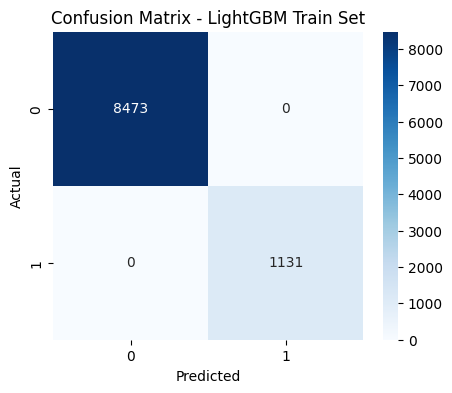

Evaluasi LightGBM Test Set
Accuracy : 0.9892
Precision: 0.9416
Recall   : 0.9682
F1-score : 0.9547
ROC-AUC  : 0.9991
Kategori : Good
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2118
           1       0.94      0.97      0.95       283

    accuracy                           0.99      2401
   macro avg       0.97      0.98      0.97      2401
weighted avg       0.99      0.99      0.99      2401



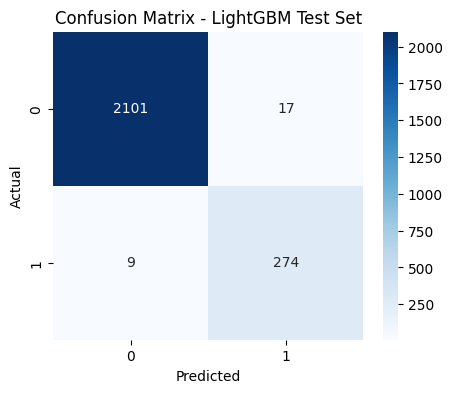

In [21]:
evaluate_model("LightGBM Train Set", pipeline, X_train, y_train)
evaluate_model("LightGBM Test Set", pipeline, X_test, y_test)

In [22]:
num_pipeline_dt = Pipeline([("scaler", StandardScaler())])

cat_pipeline_dt = Pipeline([
    ("ordinal", OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ))
])

preprocessor_dt = ColumnTransformer([
    ("num", num_pipeline_dt, num_features),
    ("cat", cat_pipeline_dt, cat_features)
])


In [25]:
model_dt = DecisionTreeClassifier(
    criterion='gini',
    splitter='best',
    max_depth=7,            # Batasan yang wajar
    min_samples_split=10,   # Membutuhkan 10 sampel untuk memisahkan
    min_samples_leaf=5,     # Membutuhkan 5 sampel di setiap daun
    max_features=None       # Menggunakan semua fitur
)

pipeline_dt = Pipeline([
    ('preprocess', preprocessor_dt),
    ('model', model_dt)
])

In [26]:
pipeline_dt.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['principal_amount',
                                                   'outstanding_amount',
                                                   'outstanding_ratio',
                                                   'avg_bill_gap', 'late_ratio',
                                                   'paid_ratio']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['marital_status',
                                                   'age_group'])])),
                ('model',
                 DecisionTreeClassifier(max_depth=7, min_samples_leaf=5,
                                        min_samples_split=10))])

Evaluasi DT Train Set
Accuracy : 0.9925
Precision: 0.9880
Recall   : 0.9478
F1-score : 0.9675
ROC-AUC  : 0.9996
Kategori : Good
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      8473
           1       0.99      0.95      0.97      1131

    accuracy                           0.99      9604
   macro avg       0.99      0.97      0.98      9604
weighted avg       0.99      0.99      0.99      9604



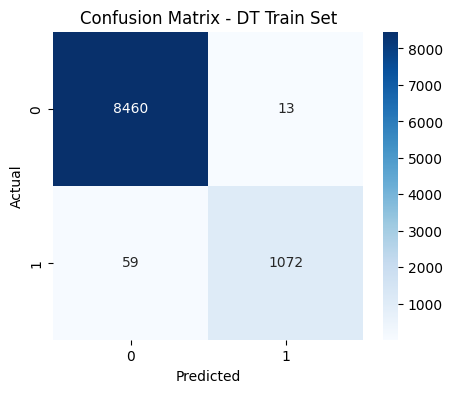

Evaluasi DT Test Set
Accuracy : 0.9858
Precision: 0.9338
Recall   : 0.9470
F1-score : 0.9404
ROC-AUC  : 0.9976
Kategori : Good
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2118
           1       0.93      0.95      0.94       283

    accuracy                           0.99      2401
   macro avg       0.96      0.97      0.97      2401
weighted avg       0.99      0.99      0.99      2401



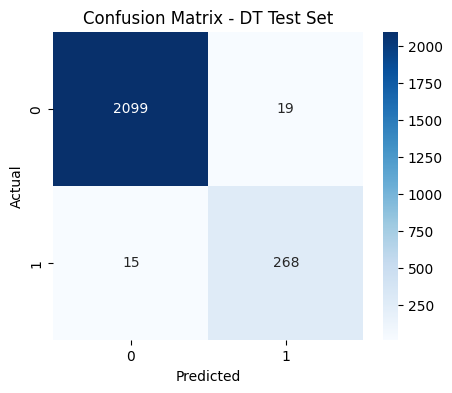

In [27]:
evaluate_model("DT Train Set", pipeline_dt, X_train, y_train)
evaluate_model("DT Test Set", pipeline_dt, X_test, y_test)

In [28]:
param_grid = {
    "model__criterion": ["gini", "entropy"],       # default = "gini"
    "model__max_depth": [None, 5, 10, 20],         # default = None
    "model__min_samples_split": [2, 5, 10],        # default = 2
    "model__min_samples_leaf": [1, 2, 5],          # default = 1
    "model__max_features": [None, "sqrt", "log2"], # default = None
    "model__class_weight": ['balanced', None]
}

In [29]:
grid_search = GridSearchCV(
    pipeline_dt,
    param_grid=param_grid,
    cv=3,
    scoring="recall",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_model_dt = grid_search.best_estimator_

Evaluasi Decision Tree Best Tuned Train Set
Accuracy : 0.9810
Precision: 0.8653
Recall   : 0.9938
F1-score : 0.9251
ROC-AUC  : 0.9985
Kategori : Good
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      8473
           1       0.87      0.99      0.93      1131

    accuracy                           0.98      9604
   macro avg       0.93      0.99      0.96      9604
weighted avg       0.98      0.98      0.98      9604



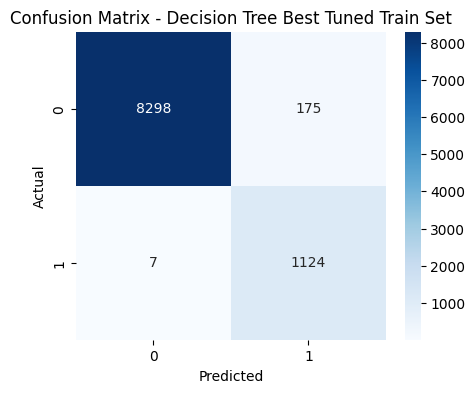

Evaluasi Decision Tree Best Tuned Test Set
Accuracy : 0.9771
Precision: 0.8434
Recall   : 0.9894
F1-score : 0.9106
ROC-AUC  : 0.9942
Kategori : Good
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2118
           1       0.84      0.99      0.91       283

    accuracy                           0.98      2401
   macro avg       0.92      0.98      0.95      2401
weighted avg       0.98      0.98      0.98      2401



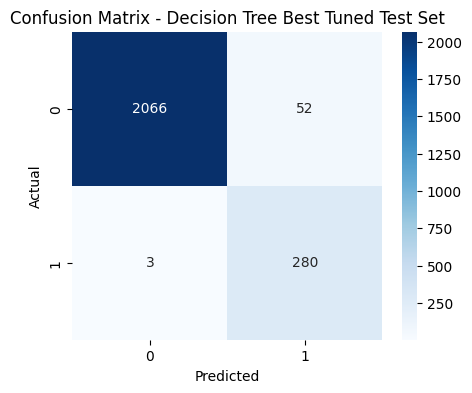

In [30]:
evaluate_model("Decision Tree Best Tuned Train Set", best_model_dt, X_train, y_train)
evaluate_model("Decision Tree Best Tuned Test Set", best_model_dt, X_test, y_test)

In [31]:
with open("best_model_dt.pkl", "wb") as file_1:
    pickle.dump(best_model_dt, file_1)